In [1]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git 

Retrieving notices: ...working... done

# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 161, in conda_http_errors
        yield
      File "/opt/conda/lib/python3.10/site-packages/conda/gateways/repodata/__init__.py", line 127, in repodata
        response.raise_for_status()
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
        raise HTTPError(http_error_msg, response=self)
    requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://conda.anaconda.org/rapidsai/linux-64/current_repodata.json
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/requests/models.py", line 971, in json
        return complexjson.loads(self.text, **kwargs)
      File "

In [48]:
import json
import cv2
import torch
from torch.utils.data import Dataset
import clip
from PIL import Image
import numpy as np 
import pandas as pd
import tensorflow as tf
from torch.utils.data import DataLoader
from IPython.display import display
import torchvision.transforms as transforms
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import Levenshtein

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn import metrics
from torch.autograd import Variable
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [4]:
# Load the pre-trained CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load('ViT-L/14@336px', device=device)

100%|████████████████████████████████████████| 891M/891M [00:06<00:00, 145MiB/s]


In [7]:
with open('/kaggle/input/vizwiz/data/Annotations/train.json', "r") as json_file:
            orig_dataset = json.load(json_file)

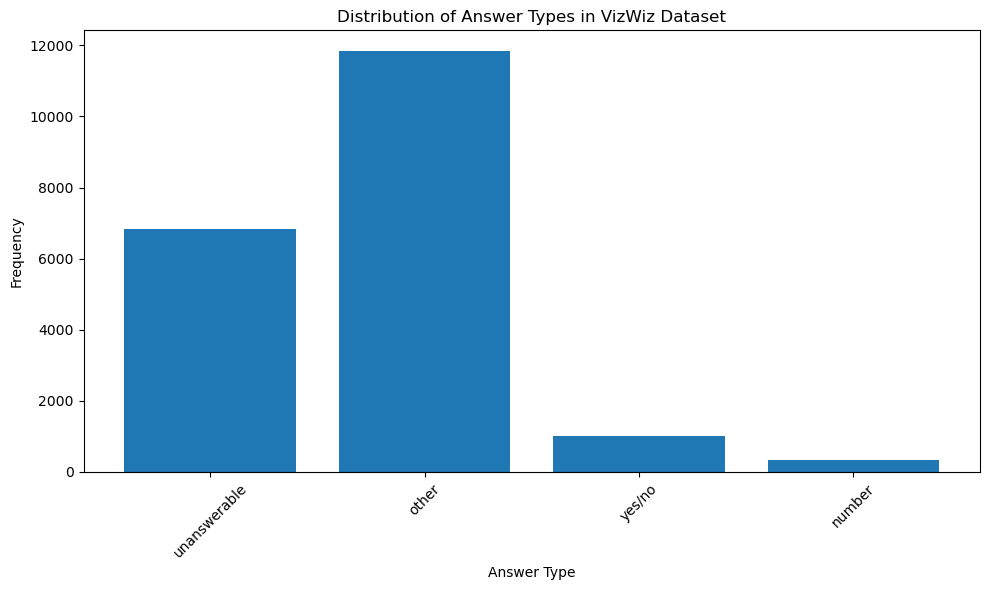

In [8]:
# Extract the desired field from the JSON data
answer_types = [entry['answer_type'] for entry in orig_dataset]

# Calculate the frequencies of each answer type
answer_type_counts = {answer_type: answer_types.count(answer_type) for answer_type in set(answer_types)}

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(answer_type_counts.keys(), answer_type_counts.values())
plt.xlabel('Answer Type')
plt.ylabel('Frequency')
plt.title('Distribution of Answer Types in VizWiz Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

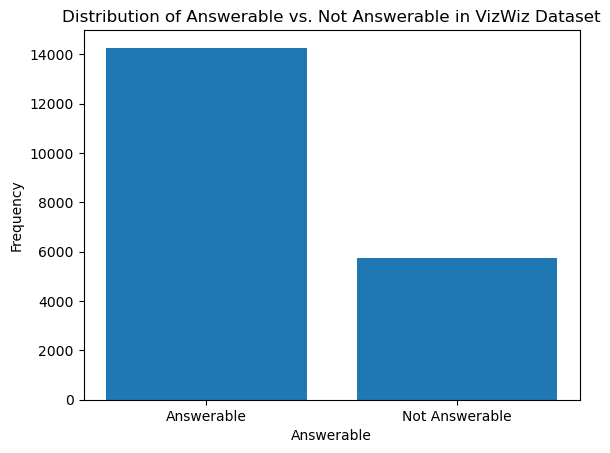

In [9]:
answerable_counts = sum(entry['answerable'] for entry in orig_dataset)
not_answerable_counts = len(orig_dataset) - answerable_counts
plt.bar(['Answerable', 'Not Answerable'], [answerable_counts, not_answerable_counts])
plt.xlabel('Answerable')
plt.ylabel('Frequency')
plt.title('Distribution of Answerable vs. Not Answerable in VizWiz Dataset')
plt.show()

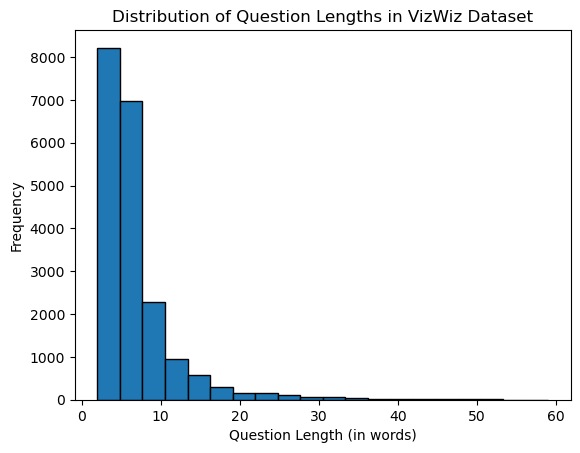

In [10]:
question_lengths = [len(entry['question'].split()) for entry in orig_dataset]
plt.hist(question_lengths, bins=20, edgecolor='black')
plt.xlabel('Question Length (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Question Lengths in VizWiz Dataset')
plt.show()

In [11]:
with open('/kaggle/input/vizwiz/data/Annotations/val.json', "r") as json_val_file:
            org_valid_dataset = json.load(json_val_file)

In [13]:
random_indices = np.random.choice(len(orig_dataset), 1000, replace=False) 
dataset = [orig_dataset[i] for i in random_indices]

In [14]:
random_indices_val = np.random.choice(len(org_valid_dataset), 500, replace=False) 
valid_dataset = [org_valid_dataset[i] for i in random_indices_val]

In [15]:
print(len(dataset))

1000


In [16]:
 def extract_unique_answertype(dataset):
        answer_type_column = []
        unique_answer_types = set()
        for item in dataset:
            answer_type = item["answer_type"]
            answer_type_column.append(answer_type) 
            unique_answer_types.add(answer_type)
        return unique_answer_types , answer_type_column

In [17]:
unique_answer_types, answer_type_column = extract_unique_answertype(dataset)
print(len(unique_answer_types))
print(unique_answer_types)
print(len(answer_type_column))

4
{'unanswerable', 'other', 'yes/no', 'number'}
1000


In [18]:
unique_answer_types_val, answer_type_column_val = extract_unique_answertype(valid_dataset)
print(len(unique_answer_types_val))
print(unique_answer_types_val)
print(len(answer_type_column_val))

4
{'unanswerable', 'other', 'yes/no', 'number'}
500


In [19]:
def extract_unique_answers(dataset):
    unique_most_common_answers = set()

    for item in dataset:

        answers = [answer['answer'] for answer in item['answers']]
        
        answer_counts = {}
        for answer in answers:
            if answer not in answer_counts:
                answer_counts[answer] = 1
            else:
                answer_counts[answer] += 1
        sorted_answers = sorted(answer_counts.items(), key=lambda x: x[1], reverse=True)
        most_common_answer = sorted_answers[0][0]
        unique_most_common_answers.add(most_common_answer)
    
    return unique_most_common_answers

In [20]:
unique_most_common_answers_train = extract_unique_answers(dataset)
#print(list(unique_most_common_answers))
print(len(unique_most_common_answers_train))

486


In [21]:
unique_most_common_answers_val = extract_unique_answers(valid_dataset)
print(len(unique_most_common_answers_val))

251


In [22]:
unique_most_common_answers = unique_most_common_answers_train.union(unique_most_common_answers_val)
print(len(unique_most_common_answers))

680


In [24]:
class myDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
      
  def __getitem__(self, index):
    item = self.dataset[index]
    image_filename = item['image']
    image_path = '/kaggle/input/vizwiz/data/Images/' + image_filename
    question = item['question']
    answers = [answer['answer'] for answer in item['answers']]
    answerable = item['answerable']
    answer_type = item['answer_type']
    augmented_flag = item['augmented_flag']
    
    #choose most common answer from the 10, then encode it.
    answer_counts = {}
    for answer in answers:
        if answer not in answer_counts:
            answer_counts[answer] = 1
        else:
            answer_counts[answer] += 1
    sorted_answers = sorted(answer_counts.items(), key=lambda x: x[1], reverse=True)
    most_common_answer = sorted_answers[0][0]
        
    answer_label  = list(unique_most_common_answers).index(most_common_answer)
    answer_onehot= np.zeros(len(unique_most_common_answers))
    answer_onehot[answer_label] = 1
    answer_type_label = list(unique_answer_types).index(answer_type)
    answer_type_onehot = np.zeros(len(unique_answer_types))
    answer_type_onehot[answer_type_label] = 1
    # Load and resize the image
    image = Image.open(image_path)
    if image is not None:
        image = image.resize((336, 336))
    else:
        # Handle case where image is not found
        print(f"Error: Unable to read image file {image_path}")
    if augmented_flag == 1: #data for augmentation
        # Apply rotation augmentation
        rotation_angles = [45, 90, 135, 180, 270]   # Specify the rotation angle
        random_index = np.random.choice(len(rotation_angles), 1, replace=False)
        rotation_angle = rotation_angles[random_index.item()] 
        augmentation_transform = transforms.RandomRotation(degrees=rotation_angle)
        image = augmentation_transform(image)
    
    #encoding Image and Questions
    image = preprocess(image).unsqueeze(0).to(device)
    question = clip.tokenize([question]).to(device)
    with torch.no_grad():
        image_encodings = clip_model.encode_image(image).to(device)
        question_encodings = clip_model.encode_text(question).to(device)
        
    encoded_input = torch.cat([image_encodings, question_encodings], dim=-1).clone().detach().to(device)
    
    
    return encoded_input, torch.tensor(answer_onehot).float().to(device), torch.tensor(answer_type_onehot).float().to(device),torch.tensor(int(answerable)).to(device)

  def __len__(self):
      return len(self.dataset) # of how many examples(images?) you have

In [25]:
org_train_data, org_test_data = train_test_split(dataset, test_size=0.05,stratify= answer_type_column,random_state=42)

In [26]:
train_data = [{**row, 'augmented_flag': 0} for row in org_train_data]
test_data = [{**row, 'augmented_flag': 0} for row in org_test_data]
valid_data = [{**row, 'augmented_flag': 0} for row in valid_dataset]
#print(train_data)

In [27]:
augmented_indices = np.random.choice(len(train_data), 100, replace=False) 
augmented_data_train = [train_data[i] for i in augmented_indices]
augmented_data_train = [{**row, 'augmented_flag': 1} for row in augmented_data_train]
#print(augemted_data_train)


In [28]:
all_train_data = train_data + augmented_data_train
print(len(all_train_data))

1050


In [29]:
# Create the train dataset
train_set = myDataset(all_train_data)
train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True,num_workers=0)

In [30]:
# Create the train dataset
valid_set = myDataset(valid_data)
valid_dataloader = DataLoader(valid_set, batch_size=128, shuffle=True,num_workers=0)

In [31]:
# Create the test dataset
test_set = myDataset(test_data)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True,num_workers=0)

In [32]:
print(train_set[0])
input_size = train_set[0][0].size()[1]
output_answer_size = train_set[0][1].size()[0]
output_answertype_size = train_set[0][2].size()[0]
print(input_size)
print(output_answer_size)
print(output_answertype_size)

(tensor([[ 0.1709,  0.2318, -0.0595,  ...,  0.1991,  0.4990, -0.5107]],
       device='cuda:0', dtype=torch.float16), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [33]:
def accuracy_calculation(output_answertype_labels, output_answer_labels, pred_output_answer, pred_output_answertype):
    predicted_answer = torch.tensor([np.argmax(row.detach().cpu(), axis=1).item() for row in pred_output_answer ])
    true_answer = np.argmax(output_answer_labels.detach().cpu(), axis=1)
    predicted_answertype = torch.tensor([np.argmax(row.detach().cpu(), axis=1).item() for row in pred_output_answertype ])
    true_answertype = np.argmax(output_answertype_labels.detach().cpu(), axis=1)
    #print(true_answer)
    #print(predicted_answer)
    answers_accuracy = accuracy_score(true_answer, predicted_answer)
    answerstype_accuracy = accuracy_score(true_answertype, predicted_answertype)
    return answers_accuracy,answerstype_accuracy

In [34]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_size = 256
        self.fc1 = nn.Linear(input_size,hidden_size) # linear 1
        self.fc2 = nn.Linear(hidden_size,output_answer_size) #op2
        self.fc3 = nn.Linear(hidden_size,output_answertype_size) #op1
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc4 = nn.Linear(output_answertype_size,output_answer_size) #linear2
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
        batch_size, sequence_length, embedding_size = x.size()
        x = x.view(batch_size, sequence_length, -1)
        x = self.fc1(x)
        x = self.layer_norm1(x)
        x = self.dropout(x)
        #x = self.sigmoid(x)

        z = self.fc3(x) #label1
        z_projected = self.fc4(z) #y
        z_projected = self.sigmoid(z_projected)
        y = self.fc2(x)
        output = y * z_projected
        return z, output


In [35]:
def run_model(model, dataloader,valid_dataloader,test_dataloader, optimizer, train=True):
    if train:
        model.train()
    pred_output_answer = []
    pred_output_answertype = []
    output_answer_labels = []
    output_answertype_labels = []
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    batch_answers_accuracy= [] 
    batch_answerstype_accuracy= []

    for (encoded_input_tensor, answer_onehot, answer_type_onehot, answerable) in dataloader:
        optimizer.zero_grad()
        predicted_answertype, predicted_output_answer = model(encoded_input_tensor)
        answers_accuracy,answerstype_accuracy = accuracy_calculation(answer_type_onehot, answer_onehot, predicted_output_answer, predicted_answertype)
        print(f'answers accuracy for this batch : {answers_accuracy*100}')
        print(f'answers type accuracy for this batch : {answerstype_accuracy*100}')
        #print(predicted_output_answer.float())
        #print(answer_onehot)
        #print(predicted_output_answer.float().shape)
        #print(torch.tensor(answer_onehot).to(device).long().shape)
        loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
        loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device) , torch.tensor(answer_type_onehot).double().to(device))  # convert target to long tensor 
        #print(predicted_output_answer.float().shape)
        total_loss += loss_.item()
        print(f'loss for this batch: {loss_}')
        loss_.backward()
        optimizer.step()
        pred_output_answer += predicted_output_answer.tolist()
        pred_output_answertype += predicted_answertype.tolist()
        output_answertype_labels += answer_type_onehot.tolist()
        output_answer_labels += answer_onehot.tolist()
        batch_answers_accuracy.append(answers_accuracy)
        batch_answerstype_accuracy.append(answerstype_accuracy)
    print("done training")
    batch_answers_accuracy_val = []
    batch_answerstype_accuracy_val=[]
    total_loss_val=0
    model.eval() 
    for (encoded_input_tensor, answer_onehot, answer_type_onehot, answerable) in valid_dataloader:
        predicted_answertype, predicted_output_answer = model(encoded_input_tensor)
        answers_accuracy,answerstype_accuracy = accuracy_calculation(answer_type_onehot, answer_onehot, predicted_output_answer, predicted_answertype)
        loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
        loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device) , torch.tensor(answer_type_onehot).double().to(device))  # convert target to long tensor 
        total_loss_val += loss_.item()
        #print(predicted_output_answer.float().shape)
        batch_answers_accuracy_val.append(answers_accuracy)
        batch_answerstype_accuracy_val.append(answerstype_accuracy)
        print(f'answers accuracy for this batch : {answers_accuracy*100}')
        print(f'answers type accuracy for this batch : {answerstype_accuracy*100}')
        print(f'validation loss for this batch: {loss_}')
    print(f'validation accuracy for answers for this epoch: {(sum(batch_answers_accuracy_val)/len(valid_dataloader))*100}')
    print(f'validation accuracy for answers type for this epoch: {(sum(batch_answerstype_accuracy_val)/len(valid_dataloader))*100}')
    print(f'validation total loss for this epoch : {total_loss_val/len(valid_dataloader)}')
    print("done validation")
    batch_answers_accuracy_test = []
    batch_answerstype_accuracy_test=[]
    total_loss_test=0
    for (encoded_input_tensor, answer_onehot, answer_type_onehot, answerable) in test_dataloader:
        predicted_answertype, predicted_output_answer = model(encoded_input_tensor)
        answers_accuracy,answerstype_accuracy = accuracy_calculation(answer_type_onehot, answer_onehot, predicted_output_answer, predicted_answertype)
        loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
        loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device) , torch.tensor(answer_type_onehot).double().to(device))  # convert target to long tensor
        total_loss_test += loss_.item()
        #print(predicted_output_answer.float().shape)
        batch_answers_accuracy_test.append(answers_accuracy)
        batch_answerstype_accuracy_test.append(answerstype_accuracy)
        print(f'answers accuracy for this batch : {answers_accuracy*100}')
        print(f'answers type accuracy for this batch : {answerstype_accuracy*100}')
        print(f'test loss for this batch: {loss_}')
    print(f'test accuracy for answers for this epoch: {(sum(batch_answers_accuracy_test)/len(test_dataloader))*100}')
    print(f'test accuracy for answers type for this epoch: {(sum(batch_answerstype_accuracy_test)/len(test_dataloader))*100}')
    print(f'test total loss for this epoch : {total_loss_test/len(test_dataloader)}')

    return output_answertype_labels, output_answer_labels, pred_output_answer, pred_output_answertype, total_loss/len(dataloader),batch_answers_accuracy,batch_answerstype_accuracy

In [36]:
print(list(unique_most_common_answers)[160])

dolce gabbana


In [38]:
model=Model().to(device)
epoch = 5
answers_accuracy=[]
answerstype_accuracy=[]
optimizer = torch.optim.Adam(model.parameters(), 0.01, weight_decay=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)
for e in range(epoch):
    output_answertype_labels,output_answer_labels,pred_output_answer,pred_output_answertype,loss,batch_answers_accuracy,batch_answerstype_accuracy=run_model(model,train_dataloader,valid_dataloader,test_dataloader,optimizer)
    #answers_accuracy = [accuracy for accuracy in batch_answers_accuracy]
    answers_accuracy.append(sum(batch_answers_accuracy)/len(batch_answers_accuracy))
    #answerstype_accuracy = [answerstype_accuracy += accuracy for accuracy in batch_answerstype_accuracy]
    answerstype_accuracy.append(sum(batch_answerstype_accuracy)/len(batch_answerstype_accuracy))
    print(f'answers_accuracy for this epoch: {answers_accuracy[e]}')
    print(f'answerstype_accuracy for this epoch: {answerstype_accuracy[e]}')
    print(loss)

/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 0.1953125
answers type accuracy for this batch : 29.1015625
loss for this batch: 8.172058723016846


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 9.9609375
answers type accuracy for this batch : 62.890625
loss for this batch: 7.470173215728311


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 7.6923076923076925
answers type accuracy for this batch : 34.61538461538461
loss for this batch: 7.8605670342021865
done training


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 14.84375
answers type accuracy for this batch : 65.625
validation loss for this batch: 6.908816177587408


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 16.40625
answers type accuracy for this batch : 70.3125
validation loss for this batch: 6.766151668771873


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 14.84375
answers type accuracy for this batch : 60.9375
validation loss for this batch: 6.793279304985619


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 20.689655172413794
answers type accuracy for this batch : 56.896551724137936
validation loss for this batch: 6.4323977017003156
validation accuracy for answers for this epoch: 16.69585129310345
validation accuracy for answers type for this epoch: 63.442887931034484
validation total loss for this epoch : 6.725161213261304
done validation


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 18.0
answers type accuracy for this batch : 62.0
test loss for this batch: 6.722534018477766
test accuracy for answers for this epoch: 18.0
test accuracy for answers type for this epoch: 62.0
test total loss for this epoch : 6.722534018477766
answers_accuracy for this epoch: 0.05949519230769231
answerstype_accuracy for this epoch: 0.4220252403846154
7.834266324315781


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 16.6015625
answers type accuracy for this batch : 64.453125
loss for this batch: 6.692132149581207


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 13.671875
answers type accuracy for this batch : 59.1796875
loss for this batch: 7.037715433943454


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 11.538461538461538
answers type accuracy for this batch : 61.53846153846154
loss for this batch: 6.6877286236272555
done training


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 22.65625
answers type accuracy for this batch : 60.9375
validation loss for this batch: 6.378038474687301


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 22.65625
answers type accuracy for this batch : 61.71875
validation loss for this batch: 6.270671102379703


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 20.3125
answers type accuracy for this batch : 60.15625
validation loss for this batch: 6.176801445629885


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 25.0
answers type accuracy for this batch : 60.3448275862069
validation loss for this batch: 6.262313669526877
validation accuracy for answers for this epoch: 22.65625
validation accuracy for answers type for this epoch: 60.78933189655172
validation total loss for this epoch : 6.271956173055942
done validation


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 22.0
answers type accuracy for this batch : 62.0
test loss for this batch: 6.36279113094641
test accuracy for answers for this epoch: 22.0
test accuracy for answers type for this epoch: 62.0
test total loss for this epoch : 6.36279113094641
answers_accuracy for this epoch: 0.1393729967948718
answerstype_accuracy for this epoch: 0.6172375801282052
6.8058587357173055


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.921875
answers type accuracy for this batch : 60.7421875
loss for this batch: 6.167253609327745


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 22.265625
answers type accuracy for this batch : 49.609375
loss for this batch: 6.391434711565531


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 23.076923076923077
answers type accuracy for this batch : 42.30769230769231
loss for this batch: 6.604988680988736
done training


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 14.84375
answers type accuracy for this batch : 71.09375
validation loss for this batch: 5.971290158034214


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 17.96875
answers type accuracy for this batch : 67.1875
validation loss for this batch: 6.088951427493467


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 17.96875
answers type accuracy for this batch : 73.4375
validation loss for this batch: 5.91553635357083


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 21.551724137931032
answers type accuracy for this batch : 67.24137931034483
validation loss for this batch: 5.6862258871137215
validation accuracy for answers for this epoch: 18.083243534482758
validation accuracy for answers type for this epoch: 69.7400323275862
validation total loss for this epoch : 5.915500956553058
done validation


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 20.0
answers type accuracy for this batch : 70.0
test loss for this batch: 6.083557682067055
test accuracy for answers for this epoch: 20.0
test accuracy for answers type for this epoch: 70.0
test total loss for this epoch : 6.083557682067055
answers_accuracy for this epoch: 0.21754807692307696
answerstype_accuracy for this epoch: 0.5088641826923077
6.3878923339606715


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.53125
answers type accuracy for this batch : 60.3515625
loss for this batch: 5.916511055423372


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 16.40625
answers type accuracy for this batch : 62.3046875
loss for this batch: 6.057568569238891


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.230769230769234
answers type accuracy for this batch : 53.84615384615385
loss for this batch: 5.9920058900033375
done training


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 21.875
answers type accuracy for this batch : 60.15625
validation loss for this batch: 5.835678473227798


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 21.09375
answers type accuracy for this batch : 57.8125
validation loss for this batch: 5.853230248672171


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 17.1875
answers type accuracy for this batch : 59.375
validation loss for this batch: 6.118123552308362


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 25.0
answers type accuracy for this batch : 52.58620689655172
validation loss for this batch: 5.787275790061172
validation accuracy for answers for this epoch: 21.2890625
validation accuracy for answers type for this epoch: 57.482489224137936
validation total loss for this epoch : 5.898577016067376
done validation


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 22.0
answers type accuracy for this batch : 57.99999999999999
test loss for this batch: 6.050581258204133
test accuracy for answers for this epoch: 22.0
test accuracy for answers type for this epoch: 57.99999999999999
test total loss for this epoch : 6.050581258204133
answers_accuracy for this epoch: 0.18389423076923075
answerstype_accuracy for this epoch: 0.5883413461538461
5.9886951715552


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.921875
answers type accuracy for this batch : 62.5
loss for this batch: 6.0160958038664685


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.53125
answers type accuracy for this batch : 60.3515625
loss for this batch: 5.8253412658604615


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 26.923076923076923
answers type accuracy for this batch : 57.692307692307686
loss for this batch: 5.601149111754506
done training


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.53125
answers type accuracy for this batch : 68.75
validation loss for this batch: 5.9052426515573435


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 20.3125
answers type accuracy for this batch : 64.84375
validation loss for this batch: 6.014059522810583


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 21.875
answers type accuracy for this batch : 62.5
validation loss for this batch: 5.899146208741641


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

answers accuracy for this batch : 19.82758620689655
answers type accuracy for this batch : 68.96551724137932
validation loss for this batch: 5.953427280080479
validation accuracy for answers for this epoch: 20.38658405172414
validation accuracy for answers type for this epoch: 66.26481681034483
validation total loss for this epoch : 5.942968915797512
done validation
answers accuracy for this batch : 18.0
answers type accuracy for this batch : 64.0
test loss for this batch: 6.1400620181717365
test accuracy for answers for this epoch: 18.0
test accuracy for answers type for this epoch: 64.0
test total loss for this epoch : 6.1400620181717365
answers_accuracy for this epoch: 0.2212540064102564
answerstype_accuracy for this epoch: 0.6018129006410257
5.814195393827145


/tmp/ipykernel_28/3301672586.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
/tmp/ipykernel_28/2691727836.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ = loss_fn(predicted_output_answer.double().squeeze(dim=1).to(device) , torch.tensor(answer_onehot).double().to(device))  # convert target to long tensor
/tmp/ipykernel_28/2691727836.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_+= loss_fn(predicted_answertype.double().squeeze(dim=1).to(device

In [41]:
class Answerability_model(nn.Module):
    def __init__(self):
        super(Answerability_model, self).__init__()
        self.hidden = nn.Linear(input_size, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)
        batch_size, sequence_length, embedding_size = x.size()
        x = x.view(batch_size, sequence_length, -1)
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [42]:
def run_answerability_model(model,dataloader,valid_dataloader,test_dataloader, optimizer,train = True ):
    if train:
        model.train()

    pred = []
    labels = []
    loss = nn.BCELoss()
    total_loss = 0
    batch_accuracy = []
    for (encoded_input_tensor, answer_onehot, answer_type_onehot, answerable) in dataloader:

        optimizer.zero_grad()
        output = model(encoded_input_tensor)
        loss_ = loss(output.double().squeeze(dim=1).squeeze(dim=1).to(device), answerable.double().to(device))
        total_loss += loss_.item()
        print(f'loss for this batch: {loss_}')
        loss_.backward()
        optimizer.step()
        pred += output.tolist()
        labels += answerable.tolist()
        binary_predictions = (output >= 0.5).int()

        # Calculate accuracy
        accuracy = (binary_predictions == answerable).float().mean().item()
        print(f'accuracy for this batch : {accuracy*100}')
        batch_accuracy.append(accuracy)
    print("done training")
    batch_accuracy_val = []
    total_loss_val=0
    model.eval()
    for (encoded_input_tensor, answer_onehot, answer_type_onehot, answerable) in valid_dataloader:
        predicted = model(encoded_input_tensor)
        binary_predictions = (predicted >= 0.5).int()

        # Calculate accuracy
        accuracy = (binary_predictions == answerable).float().mean().item()
        print(f'accuracy for this batch : {accuracy*100}')
        batch_accuracy_val.append(accuracy)
        loss_ = loss(predicted.double().squeeze(dim=1).squeeze(dim=1).to(device), answerable.double().to(device)) 
        total_loss_val += loss_.item()
        #print(predicted_output_answer.float().shape)
        print(f'validation accuracy for this batch: {accuracy}')
        print(f'validation loss for this batch: {loss_}')
    print(f'validation accuracy for this epoch: {sum(batch_accuracy_val)/len(valid_dataloader)}')
    print(f'validation loss for this epoch: {total_loss_val/len(valid_dataloader)}')
    print("done validation")
    batch_accuracy_test=[]
    total_loss_test=0
    for (encoded_input_tensor, answer_onehot, answer_type_onehot, answerable) in test_dataloader:
        predicted = model(encoded_input_tensor)
        binary_predictions = (predicted >= 0.5).int()

        # Calculate accuracy
        accuracy = (binary_predictions == answerable).float().mean().item()
        print(f'accuracy for this batch : {accuracy*100}')
        batch_accuracy_test.append(accuracy)
        loss_ = loss(predicted.double().squeeze(dim=1).squeeze(dim=1).to(device), answerable.double().to(device)) 
        total_loss_val += loss_.item()
        #print(predicted_output_answer.float().shape)
        print(f'test accuracy for this batch: {accuracy}')
        print(f'test loss for this batch: {loss_}')
    print(f'test accuracy for this epoch: {sum(batch_accuracy_test)/len(test_dataloader)}')
    print(f'test loss for this epoch: {total_loss_test/len(test_dataloader)}')
    return labels,pred,total_loss/len(dataloader),batch_accuracy

In [44]:
answerability_model=Answerability_model().to(device)
epoch = 5

optimizer = torch.optim.Adam(model.parameters(), 0.01, weight_decay=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.3, threshold=1e-4)
answerability_accuracy = []
for e in range(epoch):
    labels,pred,loss,batch_accuracy=run_answerability_model(answerability_model,train_dataloader,valid_dataloader,test_dataloader,optimizer)
    answerability_accuracy.append(sum(batch_accuracy)/len(batch_accuracy))
    print(f'loss for this epoch : {loss}')
    print(f'accuracy for this epoch : {answerability_accuracy[e]}')

/tmp/ipykernel_28/2618050107.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach().to(device)


loss for this batch: 0.6698690776078804
accuracy for this batch : 67.3583984375
loss for this batch: 0.6609736558215307
accuracy for this batch : 70.74813842773438
loss for this batch: 0.657518623806545
accuracy for this batch : 73.07692170143127
done training
accuracy for this batch : 71.240234375
validation accuracy for this batch: 0.71240234375
validation loss for this batch: 0.6596834812856375
accuracy for this batch : 73.08349609375
validation accuracy for this batch: 0.7308349609375
validation loss for this batch: 0.6615145438411891
accuracy for this batch : 71.9482421875
validation accuracy for this batch: 0.719482421875
validation loss for this batch: 0.6661963357620708
accuracy for this batch : 57.72889256477356
validation accuracy for this batch: 0.5772889256477356
validation loss for this batch: 0.6945197923380176
validation accuracy for this epoch: 0.6850021630525589
validation loss for this epoch: 0.6704785383067288
done validation
accuracy for this batch : 68.399995565414

In [63]:
answers_accuracy = [26.92, 25.0, 22.0]
answerstype_accuracy = [61.13, 68.96, 62.0]
answerability_accuracy = [71.66, 71.02, 63.77]

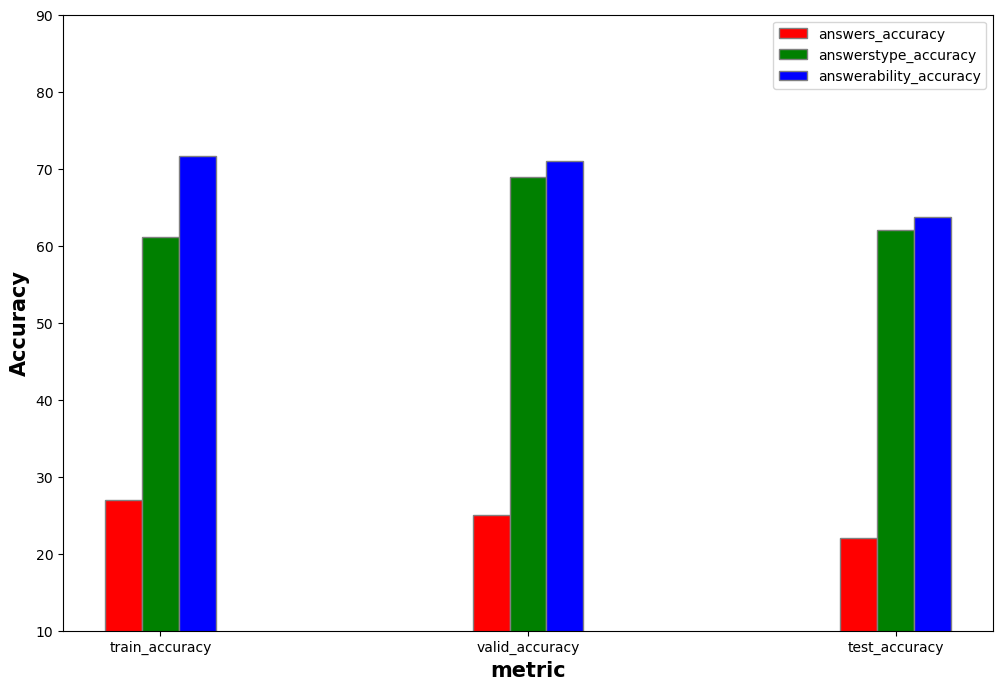

In [64]:
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, answers_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='answers_accuracy')
plt.bar(br2, answerstype_accuracy, color ='g', width = barWidth,
        edgecolor ='grey', label ='answerstype_accuracy')
plt.bar(br3, answerability_accuracy, color ='b', width = barWidth,
        edgecolor ='grey', label ='answerability_accuracy')
 
# Adding Xticks
plt.xlabel('metric', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['train_accuracy', 'valid_accuracy','test_accuracy'])
plt.ylim(10, 90)
plt.legend()
plt.show()